# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

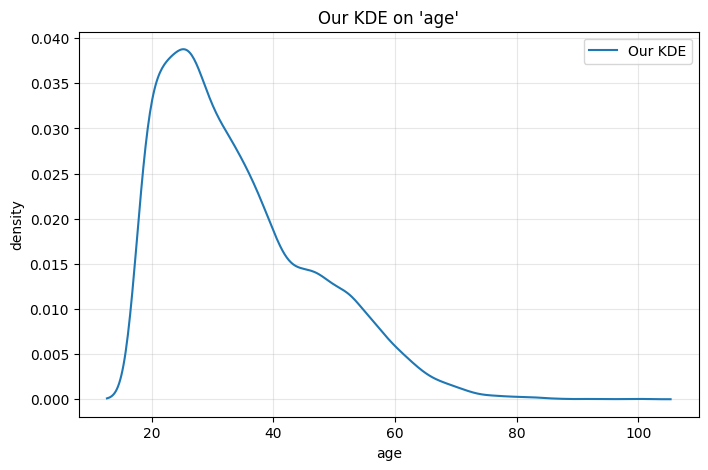

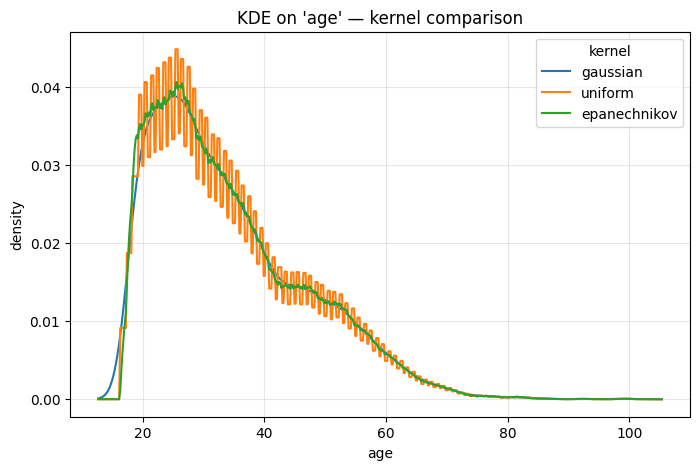

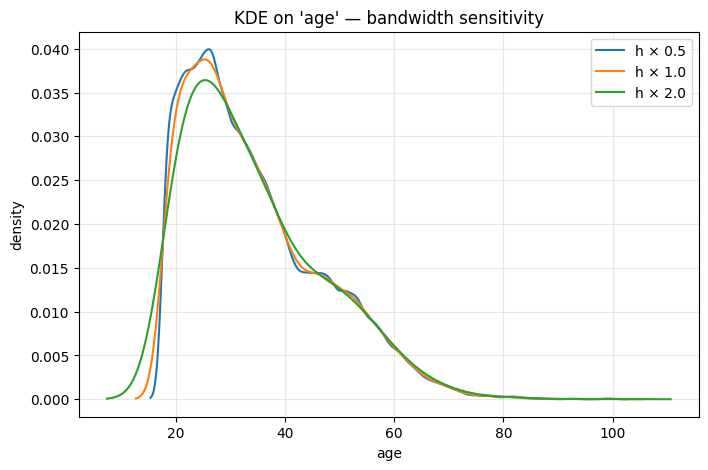

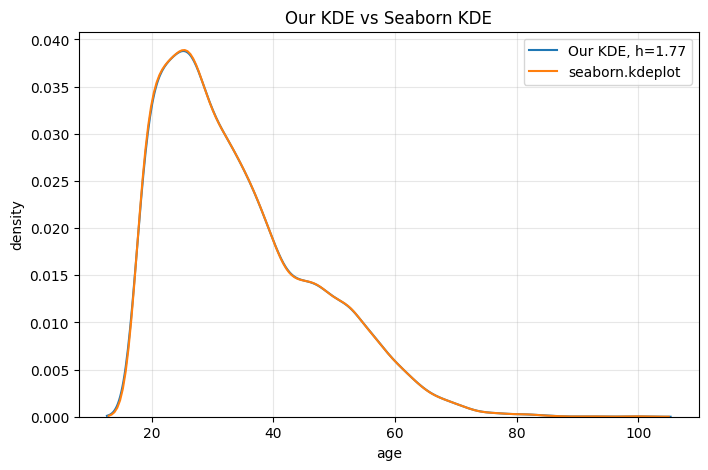

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# Silverman's plug-in bandwidth
def silverman_bw(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        raise ValueError("Silverman bandwidth requires at least 2 observations.")
    sd = np.std(x, ddof=1)
    if sd <= 0:
        raise ValueError("Silverman bandwidth undefined for zero-variance data.")
    return 1.06 * sd * n**(-1/5)

# Kernel functions
def _kernel(z: np.ndarray, kind: str) -> np.ndarray:
    kind = kind.lower()
    if kind == "gaussian":
        return np.exp(-0.5 * z**2) / np.sqrt(2*np.pi)
    elif kind in ("uniform", "bump"):
        return np.where(np.abs(z) <= 1, 0.5, 0.0)
    elif kind == "epanechnikov":
        return np.where(np.abs(z) <= 1, 0.75*(1 - z**2), 0.0)
    else:
        raise ValueError("kernel must be 'gaussian', 'uniform' (bump), or 'epanechnikov'")

# Core KDE estimator
def kde1d(
    data,
    bandwidth: float | None = None,
    kernel: str = "gaussian",
    gridsize: int = 512,
    cut: float = 3.0,
    grid: np.ndarray | None = None,
):
    # 1) Clean data
    x = pd.Series(data).dropna().astype(float).to_numpy()
    x = x[np.isfinite(x)]
    if x.size == 0:
        raise ValueError("No finite observations in data.")

    # 2) Bandwidth
    h = silverman_bw(x) if bandwidth is None else float(bandwidth)
    if not np.isfinite(h) or h <= 0:
        raise ValueError("Bandwidth must be a positive finite number.")

    # 3) Evaluation grid
    if grid is None:
        lo = x.min() - cut*h
        hi = x.max() + cut*h
        grid = np.linspace(lo, hi, int(gridsize))
    else:
        grid = np.asarray(grid, dtype=float)

    # 4) Pairwise standardized distances with SciPy cdist
    z = cdist(x.reshape(-1, 1), grid.reshape(-1, 1), metric="euclidean") / h

    # 5) Kernel weights + normalization
    K = _kernel(z, kernel)
    density = K.sum(axis=0) / (x.size * h)
    return grid, density, h

# Pretrial data in class
# Load dataset
df = pd.read_csv("/content/pretrial_data.csv")

# Demonstrate age column
x = df["age"] # The numeric variable that I chose

# 1) Our KDE
g, d, h = kde1d(x, kernel="gaussian")
fig, ax = plt.subplots(figsize=(8, 5)) # Create figure and axes for plotting
sns.lineplot(x=g, y=d, ax=ax, label="Our KDE") # Plot the KDE
ax.set_title("Our KDE on 'age'")
ax.set_xlabel("age"); ax.set_ylabel("density"); # Set labels for axes
ax.grid(True, alpha=.3); ax.legend()
plt.show()

# 2) Kernel comparison
fig, ax = plt.subplots(figsize=(8, 5))
for k in ["gaussian", "uniform", "epanechnikov"]:
    gk, dk, _ = kde1d(x, bandwidth=h, kernel=k)
    sns.lineplot(x=gk, y=dk, ax=ax, label=k)
ax.set_title("KDE on 'age' — kernel comparison")
ax.set_xlabel("age"); ax.set_ylabel("density"); ax.grid(True, alpha=.3); ax.legend(title="kernel")
plt.show()

# 3) Bandwidth sensitivity
fig, ax = plt.subplots(figsize=(8, 5))
for s in [0.5, 1.0, 2.0]:
    g_s, d_s, _ = kde1d(x, bandwidth=s*h, kernel="gaussian")
    sns.lineplot(x=g_s, y=d_s, ax=ax, label=f"h × {s}")
ax.set_title("KDE on 'age' — bandwidth sensitivity")
ax.set_xlabel("age"); ax.set_ylabel("density"); ax.grid(True, alpha=.3); ax.legend()
plt.show()

# 4) Compare wth seaborn.kdeplot
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x=g, y=d, ax=ax, label=f"Our KDE, h={h:.2f}")
sns.kdeplot(x=x.dropna(), ax=ax, label="seaborn.kdeplot")
ax.set_title("Our KDE vs Seaborn KDE")
ax.set_xlabel("age"); ax.set_ylabel("density"); ax.grid(True, alpha=.3); ax.legend()
plt.show()

The kernel density estimator for the age variable first computes Silverman’s plug-in bandwidth and defines Gaussian, Uniform, and Epanechnikov kernels. Using SciPy’s cdist, it efficiently calculates the pairwise standardized distances and then evaluates the KDE formula.

The 1st plot shows the Gaussian KDE with the Silverman bandwidth (h≈1.77). It demonstrates a main peak in the late twenties and a long, gentle tail toward older ages.

The 2nd plot compares kernel shapes: Gaussian, Uniform, and Epanechnikov produce very similar overall distributions, though the Uniform curve is more jagged, showing that kernel choice matters less than bandwidth.

The 3rd plot explores bandwidth sensitivity. Halving h produces a wiggly, under-smoothed curve, while doubling h yields an overly smooth, high-bias estimate.

The 4th plot overlays the Gaussian KDE on Seaborn’s kdeplot, and the overlap confirms that our implementation matches the standard method.

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [1]:
## 2.1
# Load data with Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/college_completion.csv')

In [2]:
## 2.2
# Data dimensions, observations, and variables included
print("Data dimensions (rows, columns):", df.shape)
print("\nNumber of observations:", df.shape[0])
print("Number of variables:", df.shape[1])
print("\nVariables included:", list(df.columns))
print("\nFirst few rows of data:")
print(df.head())

Data dimensions (rows, columns): (3798, 63)

Number of observations: 3798
Number of variables: 63

Variables included: ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsew

In [3]:
## 2.3
# Cross tabulate control and level
ct = pd.crosstab(df["control"], df["level"])
print("\nCross-tab: control × level\n", ct)

cross_tab_percent = pd.crosstab(df['control'], df['level'], normalize=True) * 100 # Calculate percentage
print("\nPercentage distribution:")
print(cross_tab_percent.round(2))
print("\n")


Cross-tab: control × level
 level                   2-year  4-year
control                               
Private for-profit         465     527
Private not-for-profit      68    1180
Public                     926     632

Percentage distribution:
level                   2-year  4-year
control                               
Private for-profit       12.24   13.88
Private not-for-profit    1.79   31.07
Public                   24.38   16.64




The 2-year category is dominated by public colleges (926, 24.38%); very few private not-for-profit (68, 1.79%); and for-profits are sizable (465, 12.24%). The 4-year category is dominated by private not-for-profit universities (1180, 31.07%); public (632, 16.64%) and for-profit (527, 13.88%) are smaller. The pattern shows that community colleges are largely public, and bachelor’s programs are mostly run by private not-for-profit universities.

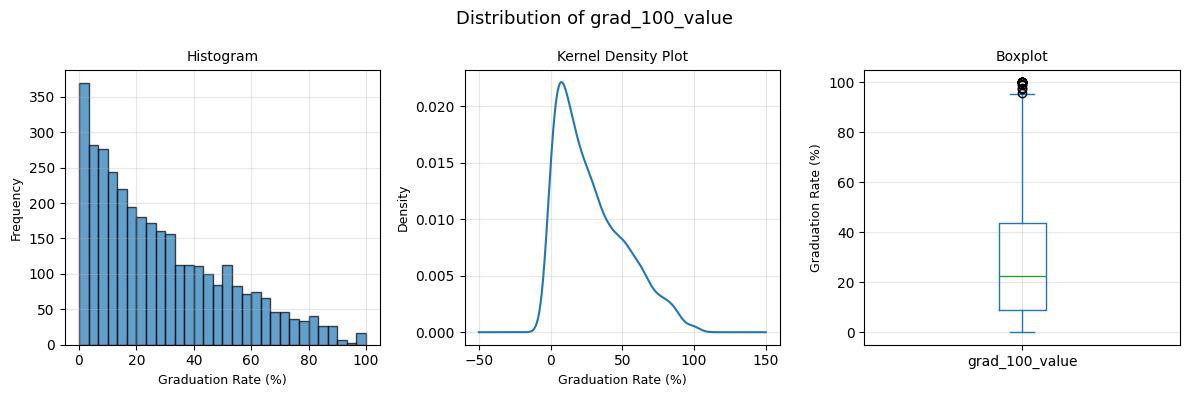


Stat descriptions for grad_100_value
 count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64
Skewness: 0.83
Kurtosis: -0.11


In [11]:
## 2.4
# Create a histogram, kernel density plot, boxplot, and statistical description for grad_100_value
from scipy.stats import skew, kurtosis

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
fig.suptitle('Distribution of grad_100_value', fontsize=13)

# Histogram
axes[0].hist(df['grad_100_value'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Graduation Rate (%)', fontsize=9)
axes[0].set_ylabel('Frequency', fontsize=9)
axes[0].set_title('Histogram', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Kernel Density Plot
df['grad_100_value'].dropna().plot(kind='density', ax=axes[1])
axes[1].set_xlabel('Graduation Rate (%)', fontsize=9)
axes[1].set_ylabel('Density', fontsize=9)
axes[1].set_title('Kernel Density Plot', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Boxplot
df['grad_100_value'].dropna().plot(kind='box', ax=axes[2])
axes[2].set_ylabel('Graduation Rate (%)', fontsize=9)
axes[2].set_title('Boxplot', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.subplots_adjust(wspace=0.3, top=0.85)
plt.show()

# Statistical descriptiions
grad_data = df['grad_100_value'].dropna()
print("\nStat descriptions for grad_100_value\n", grad_data.describe())
print(f"Skewness: {skew(grad_data):.2f}")
print(f"Kurtosis: {kurtosis(grad_data):.2f}")

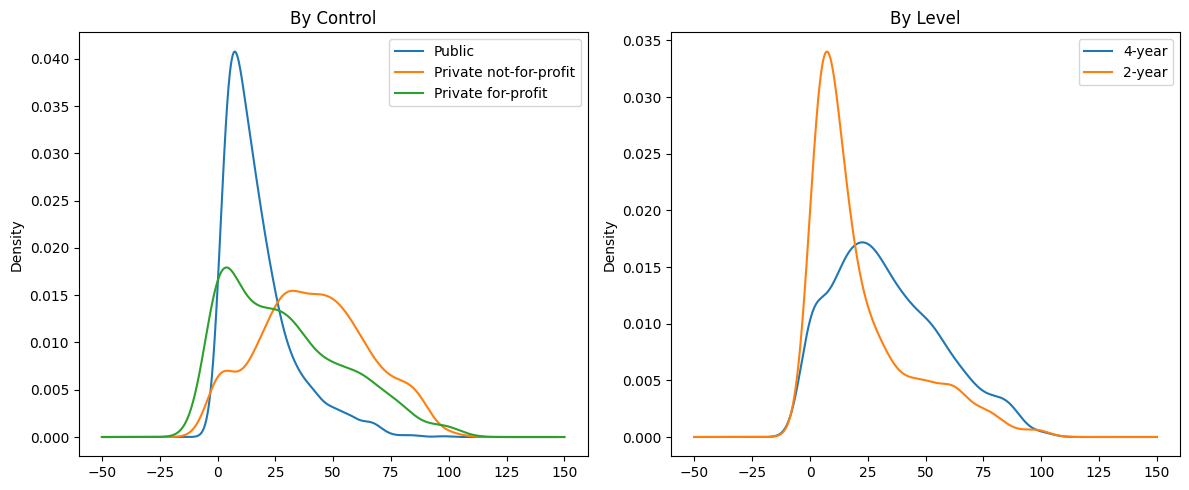


By control:
                         count   mean    std  min    25%   50%    75%    max
control                                                                     
Private for-profit       779.0  29.11  25.60  0.0   6.95  24.7  46.75  100.0
Private not-for-profit  1189.0  41.66  23.55  0.0  25.00  41.0  58.30  100.0
Public                  1499.0  17.43  14.73  0.0   6.90  13.2  23.25   97.8

By level
         count   mean    std  min   25%   50%    75%    max
level                                                      
2-year  1455.0  21.64  21.65  0.0   6.0  13.0  30.60  100.0
4-year  2012.0  33.23  23.27  0.0  15.2  29.7  49.22  100.0
By control type (ascending):
control
Private not-for-profit    41.66
Private for-profit        29.11
Public                    17.43
Name: grad_100_value, dtype: float64

By level (highest first):
level
4-year    33.23
2-year    21.64
Name: grad_100_value, dtype: float64


In [5]:
## 2.5
# Create a grouped kernel density plot by control and by level for grad_100_value.
# Use groupby and .describe to make grouped calculations of statistical descriptions of grad_100_value by level and control.

# Grouped density plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Kernel density plot grouped by control
for control in df['control'].unique():
    data = df[df['control'] == control]['grad_100_value'].dropna()
    data.plot(kind='density', label=control, ax=ax1)
ax1.set_title('By Control')
ax1.legend()

# Kernel density plot grouped by level
for level in df['level'].unique():
    data = df[df['level'] == level]['grad_100_value'].dropna()
    data.plot(kind='density', label=level, ax=ax2)
ax2.set_title('By Level')
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical descriptions
print("\nBy control:")
print(df.groupby('control')['grad_100_value'].describe().round(2))

print("\nBy level")
print(df.groupby('level')['grad_100_value'].describe().round(2))

# Best performing institutions
control_means = df.groupby('control')['grad_100_value'].mean().round(2)
level_means = df.groupby('level')['grad_100_value'].mean().round(2)

print("By control type (ascending):")
print(control_means.sort_values(ascending=False))

print("\nBy level (highest first):")
print(level_means.sort_values(ascending=False))

Distributions for private not-for-profit schools sit furthest to the right (highest densities around 35–60%), for-profits are in the middle with a wider spread, and public institutions are concentrated at the low end. By level, 4-year schools are clearly shifted right of 2-year schools.

For statistical descriptions, private not-for-profit colleges have the strongest graduation outcomes, with an average grad_100_value 41.66%, followed by private for-profit schools averaging about 29.11% and public institutions trailing at 17.43%. 4-year schools also outperform 2-year schools overall, posting an average of 33.23% compared to roughly 21.64% for two-year programs.

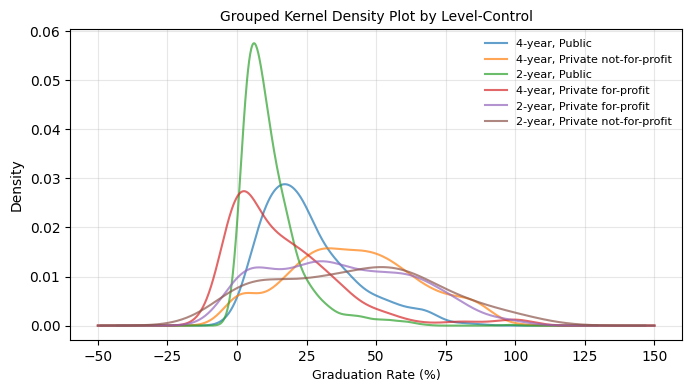


Graduation Rates by Level-Control:
                                 count   mean    std  min    25%   50%    75%  \
levelXcontrol                                                                   
2-year, Private for-profit       461.0  37.20  25.50  0.0  15.80  33.9  57.80   
2-year, Private not-for-profit    68.0  41.91  28.35  0.0  16.23  44.4  61.20   
2-year, Public                   926.0  12.40  10.89  0.0   5.10   9.4  16.18   
4-year, Private for-profit       318.0  17.38  20.79  0.0   0.00  12.5  26.32   
4-year, Private not-for-profit  1121.0  41.65  23.24  0.0  25.00  41.0  57.80   
4-year, Public                   573.0  25.56  16.40  0.0  13.60  21.8  33.80   

                                  max  
levelXcontrol                          
2-year, Private for-profit      100.0  
2-year, Private not-for-profit  100.0  
2-year, Public                   97.8  
4-year, Private for-profit      100.0  
4-year, Private not-for-profit  100.0  
4-year, Public                   86

In [6]:
## 2.6
# Create a new variable, df['levelXcontrol']=df['level']+', '+df['control'].
# Make a grouped kernel density plot.

# Create a new variable
df['levelXcontrol'] = df['level'] + ', ' + df['control']

# Grouped density plot
plt.figure(figsize=(7, 4))  # smaller figure
for combo in df['levelXcontrol'].unique():
    data = df[df['levelXcontrol'] == combo]['grad_100_value'].dropna()
    data.plot(kind='density', label=combo, alpha=0.7)

plt.title('Grouped Kernel Density Plot by Level-Control', fontsize=10)
plt.xlabel('Graduation Rate (%)', fontsize=9)
plt.legend(fontsize=8, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=1.0)
plt.show()

# Statistical descriptions
print("\nGraduation Rates by Level-Control:")
combo_stats = df.groupby('levelXcontrol')['grad_100_value'].describe().round(2)
print(combo_stats)

# Rank by mean performance
print("\nRank By Mean Performance (Ascending):")
ranked_means = df.groupby('levelXcontrol')['grad_100_value'].mean().sort_values(ascending=False)
print(ranked_means.round(2))

Combining level and control shows the private not-for-profit groups shifted farthest right in the KDEs. It indicates the highest graduation rates: mean around 41.91% for 2-year and 41.65% for 4-year. Next is 2-year private for-profit around 37.20%, 4-year public (25.56%) and 2-year public (12.4%). Meanwhile, the 2-year private not-for-profit group is small, with only 68 schools, so its top ranking should be viewed carefully.

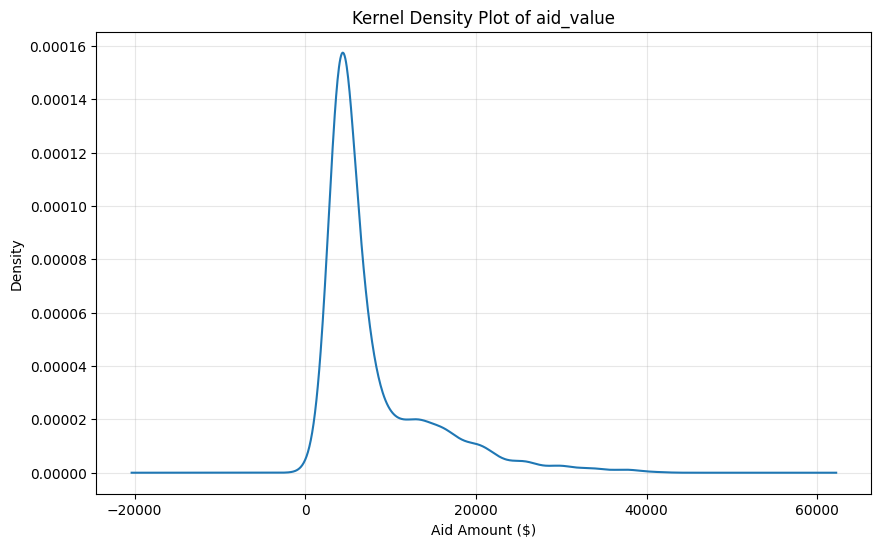

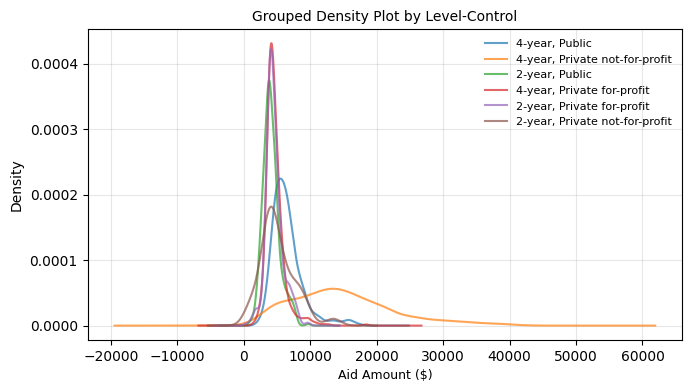


aid_value by Level-Control:
                                 count      mean      std     min      25%  \
levelXcontrol                                                                
2-year, Private for-profit       464.0   4559.68  1286.69   294.0  3818.75   
2-year, Private not-for-profit    68.0   5128.06  2590.45   934.0  3650.00   
2-year, Public                   926.0   4126.20  1260.27   881.0  3311.25   
4-year, Private for-profit       527.0   4696.06  1489.41  1580.0  3885.50   
4-year, Private not-for-profit  1180.0  14702.40  7649.78   902.0  9113.25   
4-year, Public                   632.0   6514.07  2353.72  2232.0  4990.50   

                                    50%       75%      max  
levelXcontrol                                               
2-year, Private for-profit       4286.5   5122.00   9727.0  
2-year, Private not-for-profit   4516.5   6311.50  13654.0  
2-year, Public                   3943.5   4762.00   9809.0  
4-year, Private for-profit       4364.0  

In [8]:
## 2.7
# Make a kernel density plot of aid_value. Group graph by level and control.
# Use groupby and .describe to make grouped calculations of statistical descriptions of aid_value by level and control.

# Kernel density plot of aid_value
plt.figure(figsize=(10, 6))
df['aid_value'].dropna().plot(kind='density')
plt.title('Kernel Density Plot of aid_value')
plt.xlabel('Aid Amount ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Grouped density plot by level and control
plt.figure(figsize=(7, 4))
for combo in df['levelXcontrol'].unique():
    data = df[df['levelXcontrol'] == combo]['aid_value'].dropna()
    data.plot(kind='density', label=combo, alpha=0.7)

plt.title('Grouped Density Plot by Level-Control', fontsize=10)
plt.xlabel('Aid Amount ($)', fontsize=9)
plt.legend(fontsize=8, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=1.0)
plt.show()

# Grouped statistical descriptions
print("\naid_value by Level-Control:")
aid_stats = df.groupby('levelXcontrol')['aid_value'].describe().round(2)
print(aid_stats)

print("\nRanked aid amounts (Ascending):")
ranked_aid = df.groupby('levelXcontrol')['aid_value'].mean().sort_values(ascending=False)
print(ranked_aid.round(2))

The overall KDE for aid_value is sharply peaked around 4–7k dollars with a long right tail—that tail is driven almost entirely by 4-year private not-for-profit schools, which offer much larger aid on average. Grouped stats confirm this, with mean aid being the highest for 4-year private not-for-profit (14702.40 dollars; median 13774.5 dollars), followed by 4-year public (6514.07 dollars; median 6085.0 dollars).


CORRELATION COEFFICIENTS:
Overall: 0.576

By Level:
4-year: 0.670
2-year: 0.211

By Control:
Public: 0.482
Private not-for-profit: 0.602
Private for-profit: 0.188


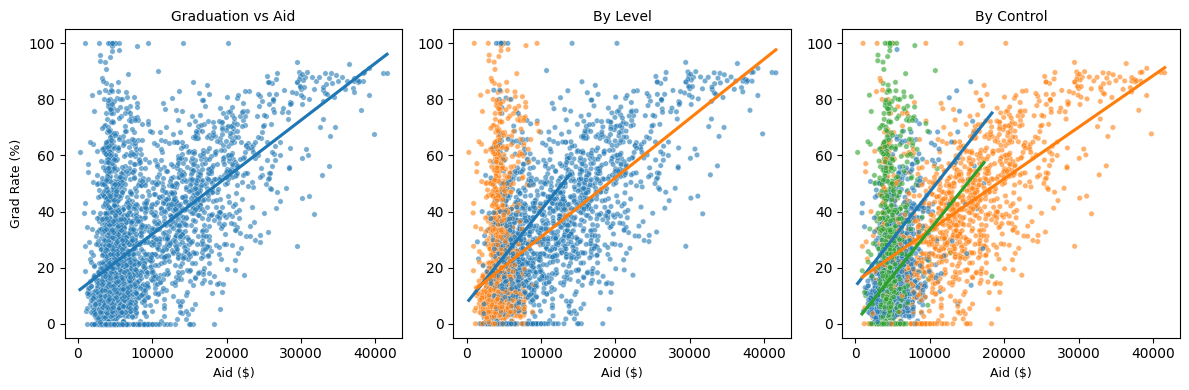

In [10]:
## 2.8
# Make a scatterplot of grad_100_value by aid_value.
# Now make the same plot, grouping by level and then control.

fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

# Scatterplot
sns.scatterplot(
    data=df, x="aid_value", y="grad_100_value", s=15, alpha=0.6, ax=axes[0]
)
sns.regplot(
    data=df, x="aid_value", y="grad_100_value", scatter=False, ci=None, ax=axes[0]
)
axes[0].set_title("Graduation vs Aid", fontsize=10)
axes[0].set_xlabel("Aid ($)", fontsize=9)
axes[0].set_ylabel("Grad Rate (%)", fontsize=9)

# By level
sns.scatterplot(
    data=df, x="aid_value", y="grad_100_value", hue="level",
    s=15, alpha=0.6, ax=axes[1], legend=False
)
for lv, sub in df.groupby("level"):
    sns.regplot(
        data=sub, x="aid_value", y="grad_100_value",
        scatter=False, ci=None, ax=axes[1]
    )
axes[1].set_title("By Level", fontsize=10)
axes[1].set_xlabel("Aid ($)", fontsize=9)
axes[1].set_ylabel("")

# By control
sns.scatterplot(
    data=df, x="aid_value", y="grad_100_value", hue="control",
    s=15, alpha=0.6, ax=axes[2], legend=False
)
for ct, sub in df.groupby("control"):
    sns.regplot(
        data=sub, x="aid_value", y="grad_100_value",
        scatter=False, ci=None, ax=axes[2]
    )
axes[2].set_title("By Control", fontsize=10)
axes[2].set_xlabel("Aid ($)", fontsize=9)
axes[2].set_ylabel("")

# Correlation analysis
print("\nCORRELATION COEFFICIENTS:")
print(f"Overall: {df['aid_value'].corr(df['grad_100_value']):.3f}")

print("\nBy Level:")
for level in df['level'].unique():
    corr = df[df['level'] == level]['aid_value'].corr(df['grad_100_value'])
    print(f"{level}: {corr:.3f}")

print("\nBy Control:")
for control in df['control'].unique():
    corr = df[df['control'] == control]['aid_value'].corr(df['grad_100_value'])
    print(f"{control}: {corr:.3f}")

The scatterplots show a clear positive relationship. Schools that provide more average aid tend to have higher on-time graduation rates. When grouped by level, the connection is strongest for 4-year colleges (correlation 0.670) and much weaker for 2-year schools (0.211). Grouping by control, the effect is strongest at private not-for-profit institutions (0.602), moderate for public (0.482), and minimal for private for-profit (0.188).

Aid seems to boost graduation rates most for 4-year, private not-for-profit colleges.